In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    precision_recall_fscore_support
)
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

## Load the Emotion Analyzer

In [5]:
from emotion import emotion_analyzer, EmotionAnalyzer

print("Emotion Analyzer loaded successfully")
print(f"Available emotion labels: {emotion_analyzer.EMOTION_LABELS}")
print(f"Model ID: {emotion_analyzer._model_id}")

Emotion Analyzer loaded successfully
Available emotion labels: ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']
Model ID: j-hartmann/emotion-english-distilroberta-base


## Create Test Dataset

We'll create a diverse test dataset with known emotions to evaluate the model's performance.

In [6]:
# Curated test dataset with labeled emotions
test_data = [
    # Anger
    ("I'm so furious about this situation!", "anger"),
    ("This makes me absolutely livid and frustrated!", "anger"),
    ("I can't believe they did this, I'm outraged!", "anger"),
    ("Stop bothering me, I'm really annoyed!", "anger"),
    ("This is completely unacceptable and infuriating!", "anger"),
    
    # Joy
    ("I'm so happy and excited about this news!", "joy"),
    ("This is the best day ever, I feel amazing!", "joy"),
    ("I'm thrilled and overjoyed with the results!", "joy"),
    ("What a wonderful experience, I'm so grateful!", "joy"),
    ("I love this so much, it brings me pure happiness!", "joy"),
    
    # Sadness
    ("I feel so heartbroken and depressed about this.", "sadness"),
    ("This makes me really sad and disappointed.", "sadness"),
    ("I'm feeling down and melancholic today.", "sadness"),
    ("Everything feels hopeless and gloomy.", "sadness"),
    ("I miss them so much, it hurts.", "sadness"),
    
    # Fear
    ("I'm really scared and anxious about what might happen.", "fear"),
    ("This situation terrifies me completely.", "fear"),
    ("I'm worried and afraid of the consequences.", "fear"),
    ("The thought of this makes me nervous and panicked.", "fear"),
    ("I feel threatened and unsafe in this environment.", "fear"),
    
    # Surprise
    ("Wow, I didn't expect that at all!", "surprise"),
    ("This is so unexpected and shocking!", "surprise"),
    ("I'm amazed and astonished by this revelation!", "surprise"),
    ("What a surprising turn of events!", "surprise"),
    ("I can't believe this just happened, so unexpected!", "surprise"),
    
    # Disgust
    ("This is absolutely revolting and disgusting.", "disgust"),
    ("I find this repulsive and nauseating.", "disgust"),
    ("That's gross and makes me feel sick.", "disgust"),
    ("I'm appalled by this disturbing behavior.", "disgust"),
    ("This is vile and completely repugnant.", "disgust"),
    
    # Neutral
    ("The meeting is scheduled for 3 PM tomorrow.", "neutral"),
    ("Please submit the report by end of day.", "neutral"),
    ("The weather forecast shows rain this week.", "neutral"),
    ("Here is the information you requested.", "neutral"),
    ("The document has been updated accordingly.", "neutral"),
]

# Create DataFrame
test_df = pd.DataFrame(test_data, columns=['text', 'true_emotion'])

print(f"Test dataset size: {len(test_df)}")
print(f"\nEmotion distribution:")
print(test_df['true_emotion'].value_counts())
print(f"\nSample texts:")
display(test_df.head(10))

Test dataset size: 35

Emotion distribution:
true_emotion
anger       5
joy         5
sadness     5
fear        5
surprise    5
disgust     5
neutral     5
Name: count, dtype: int64

Sample texts:


,text,true_emotion
0,I'm so furious about this situation!,anger
1,This makes me absolutely livid and frustrated!,anger
2,"I can't believe they did this, I'm outraged!",anger
3,"Stop bothering me, I'm really annoyed!",anger
4,This is completely unacceptable and infuriating!,anger
5,I'm so happy and excited about this news!,joy
6,"This is the best day ever, I feel amazing!",joy
7,I'm thrilled and overjoyed with the results!,joy
8,"What a wonderful experience, I'm so grateful!",joy
9,"I love this so much, it brings me pure happiness!",joy


## Generate Predictions

In [7]:
# Analyze all test samples
predictions = []
confidence_scores = []
all_emotion_scores = []

print("Analyzing test samples...\n")

for idx, row in test_df.iterrows():
    result = emotion_analyzer.analyze_single(row['text'])
    predictions.append(result['primary_emotion'])
    confidence_scores.append(result['confidence'])
    all_emotion_scores.append(result['all_scores'])
    
    # Show progress for first few
    if idx < 5:
        print(f"Text: {row['text'][:50]}...")
        print(f"True: {row['true_emotion']} | Predicted: {result['primary_emotion']} (conf: {result['confidence']:.3f})")
        print("-" * 80)

# Add predictions to dataframe
test_df['predicted_emotion'] = predictions
test_df['confidence'] = confidence_scores

print(f"\nPredictions completed for {len(test_df)} samples")
print(f"Average confidence: {np.mean(confidence_scores):.3f}")

Analyzing test samples...



You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Text: I'm so furious about this situation!...
True: anger | Predicted: anger (conf: 0.983)
--------------------------------------------------------------------------------
Text: This makes me absolutely livid and frustrated!...
True: anger | Predicted: anger (conf: 0.985)
--------------------------------------------------------------------------------
Text: I can't believe they did this, I'm outraged!...
True: anger | Predicted: anger (conf: 0.974)
--------------------------------------------------------------------------------
Text: Stop bothering me, I'm really annoyed!...
True: anger | Predicted: anger (conf: 0.945)
--------------------------------------------------------------------------------
Text: This is completely unacceptable and infuriating!...
True: anger | Predicted: anger (conf: 0.969)
--------------------------------------------------------------------------------

Predictions completed for 35 samples
Average confidence: 0.946


## Overall Confusion Matrix

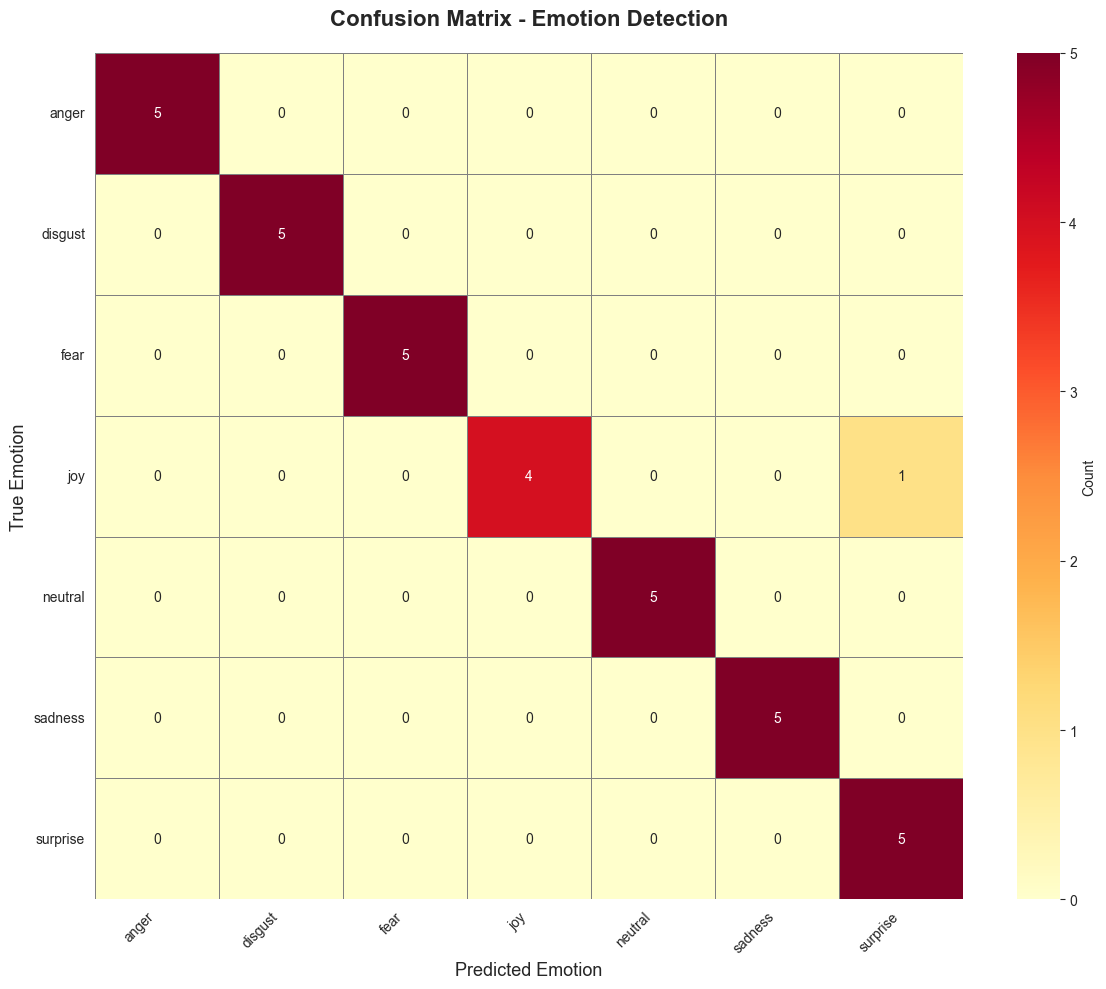


Per-Emotion Accuracy:
Anger       : 100.00% (5/5)
Disgust     : 100.00% (5/5)
Fear        : 100.00% (5/5)
Joy         : 80.00% (4/5)
Neutral     : 100.00% (5/5)
Sadness     : 100.00% (5/5)
Surprise    : 100.00% (5/5)


In [8]:
# Calculate confusion matrix
cm = confusion_matrix(test_df['true_emotion'], test_df['predicted_emotion'], 
                      labels=emotion_analyzer.EMOTION_LABELS)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrRd', 
            xticklabels=emotion_analyzer.EMOTION_LABELS,
            yticklabels=emotion_analyzer.EMOTION_LABELS,
            cbar_kws={'label': 'Count'},
            linewidths=0.5,
            linecolor='gray')
plt.title('Confusion Matrix - Emotion Detection', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Emotion', fontsize=13)
plt.xlabel('Predicted Emotion', fontsize=13)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Calculate per-emotion accuracy
print("\nPer-Emotion Accuracy:")
print("=" * 50)
for idx, emotion in enumerate(emotion_analyzer.EMOTION_LABELS):
    if cm[idx].sum() > 0:
        accuracy = cm[idx, idx] / cm[idx].sum()
        print(f"{emotion.capitalize():12s}: {accuracy:.2%} ({cm[idx, idx]}/{cm[idx].sum()})")

## Classification Metrics

In [9]:
# Overall accuracy
accuracy = accuracy_score(test_df['true_emotion'], test_df['predicted_emotion'])

print(f"Overall Accuracy: {accuracy:.4f} ({accuracy:.2%})\n")

# Detailed classification report
print("Detailed Classification Report:")
print("=" * 70)
report = classification_report(test_df['true_emotion'], test_df['predicted_emotion'],
                              labels=emotion_analyzer.EMOTION_LABELS,
                              target_names=emotion_analyzer.EMOTION_LABELS,
                              zero_division=0)
print(report)

Overall Accuracy: 0.9714 (97.14%)

Detailed Classification Report:
              precision    recall  f1-score   support

       anger       1.00      1.00      1.00         5
     disgust       1.00      1.00      1.00         5
        fear       1.00      1.00      1.00         5
         joy       1.00      0.80      0.89         5
     neutral       1.00      1.00      1.00         5
     sadness       1.00      1.00      1.00         5
    surprise       0.83      1.00      0.91         5

    accuracy                           0.97        35
   macro avg       0.98      0.97      0.97        35
weighted avg       0.98      0.97      0.97        35



## Confidence Score Analysis

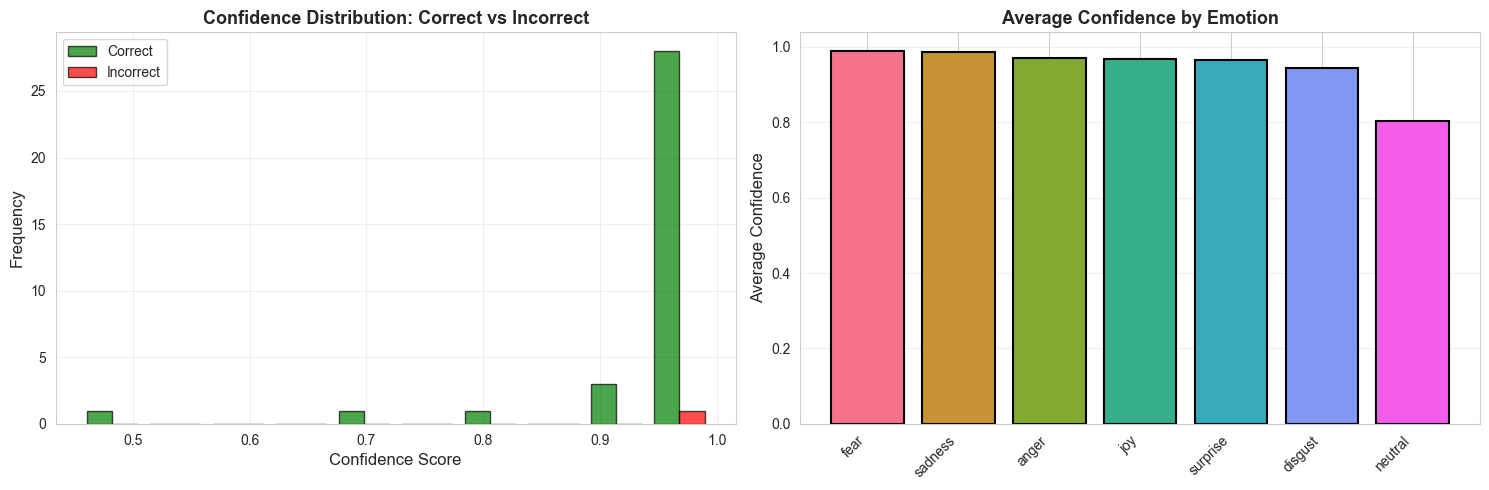


Average confidence for correct predictions: 0.946
Average confidence for incorrect predictions: 0.948


In [10]:
# Analyze confidence scores
test_df['correct'] = test_df['true_emotion'] == test_df['predicted_emotion']

# Plot confidence distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Confidence for correct vs incorrect predictions
correct_conf = test_df[test_df['correct']]['confidence']
incorrect_conf = test_df[~test_df['correct']]['confidence']

axes[0].hist([correct_conf, incorrect_conf], bins=10, label=['Correct', 'Incorrect'],
            color=['green', 'red'], alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Confidence Score', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Confidence Distribution: Correct vs Incorrect', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Confidence by emotion
emotion_conf = test_df.groupby('true_emotion')['confidence'].mean().sort_values(ascending=False)
axes[1].bar(range(len(emotion_conf)), emotion_conf.values, 
           color=sns.color_palette('husl', len(emotion_conf)),
           edgecolor='black', linewidth=1.5)
axes[1].set_xticks(range(len(emotion_conf)))
axes[1].set_xticklabels(emotion_conf.index, rotation=45, ha='right')
axes[1].set_ylabel('Average Confidence', fontsize=12)
axes[1].set_title('Average Confidence by Emotion', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\nAverage confidence for correct predictions: {correct_conf.mean():.3f}")
print(f"Average confidence for incorrect predictions: {incorrect_conf.mean():.3f}")

## Misclassification Analysis

In [11]:
# Show misclassified examples
misclassified = test_df[~test_df['correct']]

if len(misclassified) > 0:
    print(f"Misclassified Samples: {len(misclassified)}\n")
    print("=" * 100)
    
    for idx, row in misclassified.iterrows():
        print(f"Text: {row['text']}")
        print(f"True Emotion: {row['true_emotion']} | Predicted: {row['predicted_emotion']} (confidence: {row['confidence']:.3f})")
        print("-" * 100)
else:
    print("🎉 No misclassifications! Perfect accuracy!")

Misclassified Samples: 1

Text: This is the best day ever, I feel amazing!
True Emotion: joy | Predicted: surprise (confidence: 0.948)
----------------------------------------------------------------------------------------------------


## Emotion Score Distributions

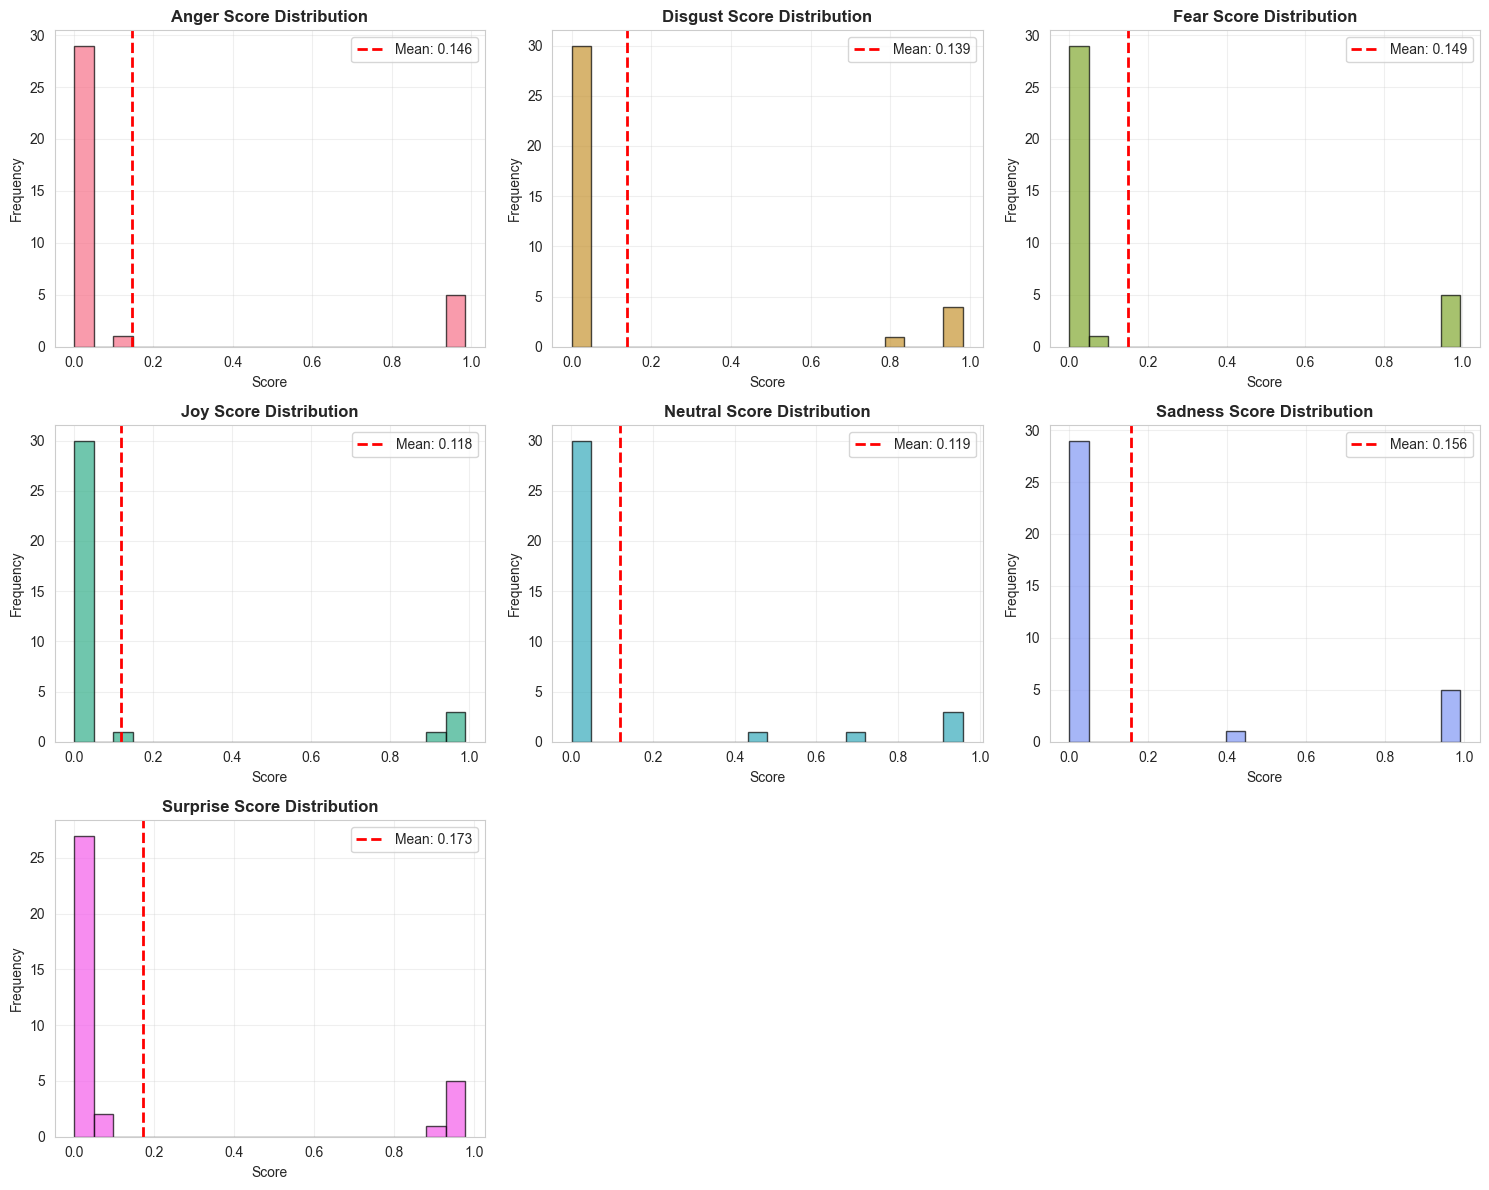

In [12]:
# Analyze score distributions for each emotion
n_emotions = len(emotion_analyzer.EMOTION_LABELS)
n_cols = 3
n_rows = (n_emotions + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
axes = axes.flatten()

for idx, emotion in enumerate(emotion_analyzer.EMOTION_LABELS):
    # Get all scores for this emotion across all samples
    scores = [scores_dict.get(emotion, 0) for scores_dict in all_emotion_scores]
    
    axes[idx].hist(scores, bins=20, color=sns.color_palette('husl', n_emotions)[idx],
                  edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'{emotion.capitalize()} Score Distribution', fontweight='bold')
    axes[idx].set_xlabel('Score')
    axes[idx].set_ylabel('Frequency')
    axes[idx].grid(True, alpha=0.3)
    axes[idx].axvline(np.mean(scores), color='red', linestyle='--', 
                     linewidth=2, label=f'Mean: {np.mean(scores):.3f}')
    axes[idx].legend()

# Hide extra subplots
for idx in range(n_emotions, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

## Test Custom Examples

In [13]:
# Test with custom examples
custom_texts = [
    "I absolutely love this new feature, it's incredible!",
    "This is the worst experience I've ever had.",
    "I'm really worried about the upcoming exam.",
    "The package will arrive on Monday.",
    "That movie was so scary, I couldn't sleep!",
    "I'm devastated by the loss of my pet.",
    "I never expected to win this competition!",
]

print("\nTesting Custom Examples:")
print("=" * 90)

for text in custom_texts:
    result = emotion_analyzer.analyze_single(text, top_k=3)
    
    # Emoji mapping
    emoji_map = {
        'joy': '😊', 'anger': '😠', 'sadness': '😢', 
        'fear': '😨', 'surprise': '😲', 'disgust': '🤢', 'neutral': '😐'
    }
    
    emoji = emoji_map.get(result['primary_emotion'], '❓')
    
    print(f"{emoji} {result['primary_emotion'].upper()} (conf: {result['confidence']:.3f})")
    print(f"   Text: {text}")
    print(f"   Top emotions: {result['emotion_distribution']}")
    print("-" * 90)


Testing Custom Examples:
😊 JOY (conf: 0.893)
   Text: I absolutely love this new feature, it's incredible!
   Top emotions: {'joy': 0.893, 'surprise': 0.075, 'neutral': 0.02}
------------------------------------------------------------------------------------------
🤢 DISGUST (conf: 0.980)
   Text: This is the worst experience I've ever had.
   Top emotions: {'disgust': 0.98, 'anger': 0.009, 'sadness': 0.005}
------------------------------------------------------------------------------------------
😨 FEAR (conf: 0.984)
   Text: I'm really worried about the upcoming exam.
   Top emotions: {'fear': 0.984, 'sadness': 0.005, 'surprise': 0.004}
------------------------------------------------------------------------------------------
😐 NEUTRAL (conf: 0.707)
   Text: The package will arrive on Monday.
   Top emotions: {'neutral': 0.707, 'joy': 0.195, 'surprise': 0.07}
------------------------------------------------------------------------------------------
😨 FEAR (conf: 0.962)
   Text: That

## Batch Analysis - Emotional Context

Emotional Context Analysis:
Dominant Emotion: SURPRISE
Dominant Score: 0.165
Average Confidence: 0.946
Total Analyzed: 35

Emotion Breakdown:
  Surprise    : 0.165
  Fear        : 0.141
  Sadness     : 0.141
  Anger       : 0.139
  Disgust     : 0.135
  Neutral     : 0.115
  Joy         : 0.111


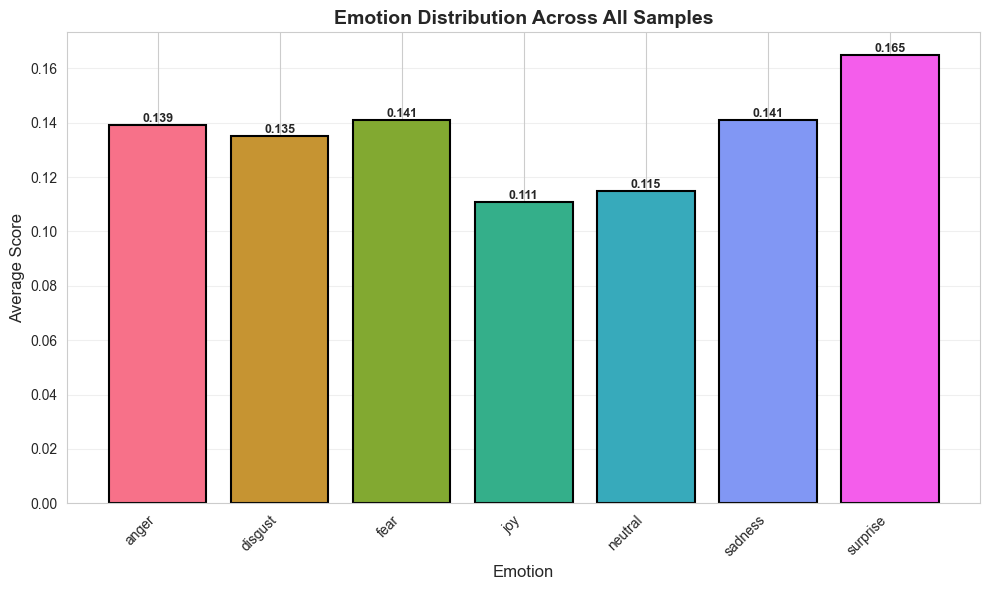

In [14]:
# Analyze emotional context across all test samples
emotional_context = emotion_analyzer.get_emotional_context(test_df['text'].tolist())

print("Emotional Context Analysis:")
print("=" * 60)
print(f"Dominant Emotion: {emotional_context['dominant_emotion'].upper()}")
print(f"Dominant Score: {emotional_context['dominant_score']:.3f}")
print(f"Average Confidence: {emotional_context['average_confidence']:.3f}")
print(f"Total Analyzed: {emotional_context['total_analyzed']}")
print(f"\nEmotion Breakdown:")
for emotion, score in sorted(emotional_context['emotion_breakdown'].items(), 
                            key=lambda x: x[1], reverse=True):
    print(f"  {emotion.capitalize():12s}: {score:.3f}")

# Visualize emotion breakdown
plt.figure(figsize=(10, 6))
emotions = list(emotional_context['emotion_breakdown'].keys())
scores = list(emotional_context['emotion_breakdown'].values())

colors = sns.color_palette('husl', len(emotions))
bars = plt.bar(emotions, scores, color=colors, edgecolor='black', linewidth=1.5)
plt.xlabel('Emotion', fontsize=12)
plt.ylabel('Average Score', fontsize=12)
plt.title('Emotion Distribution Across All Samples', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}',
            ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

## Performance Summary


EMOTION DETECTION MODEL PERFORMANCE SUMMARY


,Emotion,Precision,Recall,F1-Score,Support
0,anger,1.000,1.000,1.000,5
1,disgust,1.000,1.000,1.000,5
2,fear,1.000,1.000,1.000,5
3,joy,1.000,0.800,0.889,5
4,neutral,1.000,1.000,1.000,5
5,sadness,1.000,1.000,1.000,5
6,surprise,0.833,1.000,0.909,5
7,AVERAGE,0.976,0.971,0.971,35


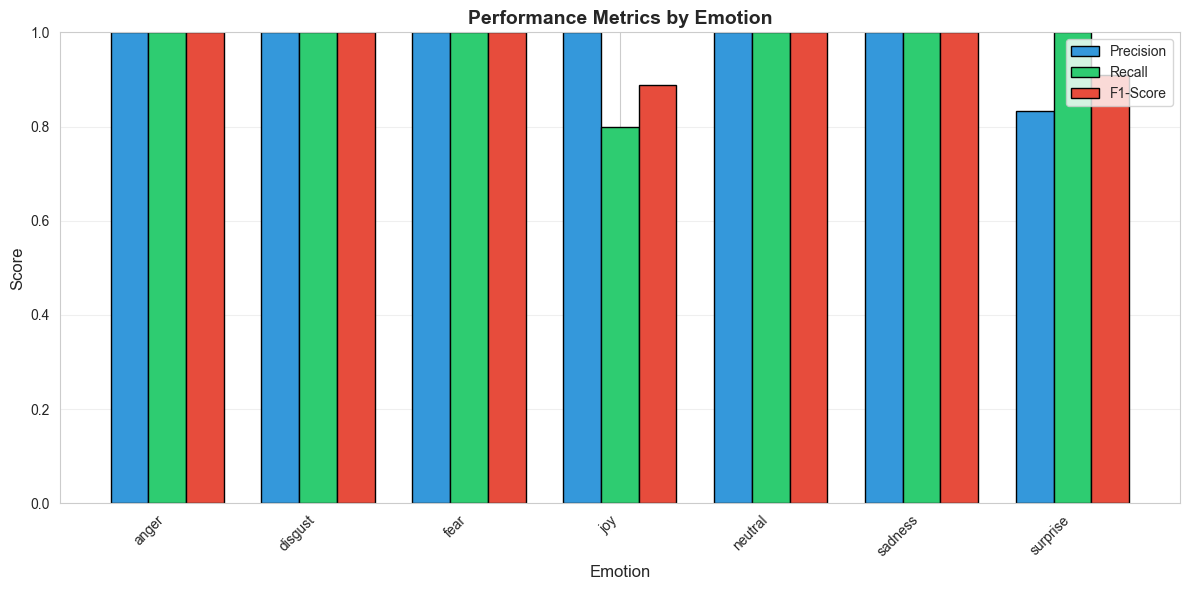

In [15]:
# Calculate per-class metrics
precision, recall, f1, support = precision_recall_fscore_support(
    test_df['true_emotion'], 
    test_df['predicted_emotion'],
    labels=emotion_analyzer.EMOTION_LABELS,
    zero_division=0
)

# Create summary DataFrame
summary_df = pd.DataFrame({
    'Emotion': emotion_analyzer.EMOTION_LABELS,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

# Add average row
avg_row = pd.DataFrame({
    'Emotion': ['AVERAGE'],
    'Precision': [precision.mean()],
    'Recall': [recall.mean()],
    'F1-Score': [f1.mean()],
    'Support': [support.sum()]
})

summary_df = pd.concat([summary_df, avg_row], ignore_index=True)

print("\n" + "=" * 70)
print("EMOTION DETECTION MODEL PERFORMANCE SUMMARY")
print("=" * 70)
display(summary_df.style.format({
    'Precision': '{:.3f}',
    'Recall': '{:.3f}',
    'F1-Score': '{:.3f}',
    'Support': '{:.0f}'
}))

# Visualize metrics comparison
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(emotion_analyzer.EMOTION_LABELS))
width = 0.25

bars1 = ax.bar(x - width, precision, width, label='Precision', color='#3498db', edgecolor='black')
bars2 = ax.bar(x, recall, width, label='Recall', color='#2ecc71', edgecolor='black')
bars3 = ax.bar(x + width, f1, width, label='F1-Score', color='#e74c3c', edgecolor='black')

ax.set_xlabel('Emotion', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Performance Metrics by Emotion', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(emotion_analyzer.EMOTION_LABELS, rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim([0, 1.0])

plt.tight_layout()
plt.show()

## Save Evaluation Results

In [16]:
import json
from pathlib import Path

# Prepare results dictionary
results = {
    'model_id': emotion_analyzer._model_id,
    'overall_accuracy': float(accuracy),
    'average_confidence': float(np.mean(confidence_scores)),
    'per_emotion_metrics': {
        emotion: {
            'precision': float(p),
            'recall': float(r),
            'f1_score': float(f),
            'support': int(s)
        }
        for emotion, p, r, f, s in zip(emotion_analyzer.EMOTION_LABELS, precision, recall, f1, support)
    },
    'confusion_matrix': cm.tolist(),
    'test_size': len(test_df),
    'misclassified_count': len(misclassified),
    'emotional_context': emotional_context
}

# Save to file
BASE_DIR = Path.cwd()
results_path = BASE_DIR / 'emotion_evaluation_results.json'

with open(results_path, 'w') as f:
    json.dump(results, f, indent=2)

print(f"\n✅ Evaluation results saved to: {results_path}")

# Save test results to CSV
csv_path = BASE_DIR / 'emotion_test_results.csv'
test_df.to_csv(csv_path, index=False)
print(f"✅ Test results saved to: {csv_path}")


✅ Evaluation results saved to: /home/sulav/Code/sochnepal/ai-service/emotion_evaluation_results.json
✅ Test results saved to: /home/sulav/Code/sochnepal/ai-service/emotion_test_results.csv
